<center><h1>Time Series Classification Part 2: Binary and Multiclass Classification</h1></center>
<br>
<br>

## 1. Time Series Classification Part 1: Feature Creation/Extraction

### (a) Obtain Data

Import packages

In [1]:
import pandas as pd
import glob
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import RFECV
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.pipeline import make_pipeline

Get the AReM Data Set

In [2]:
# Dictionary to store dataframe
AReM_Data_Set = {}
base_root = '../Data/AReM'

# Iterate over each folder
for folder_path in glob.glob(f"{base_root}/*/"):
    # Return the base name of pathname path.
    folder_name = os.path.basename(os.path.dirname(folder_path))
    csv_files = glob.glob(f"{folder_path}/*.csv")
    
    for file_path in csv_files:
        # Split the pathname path into a pair (root, ext)
        file_name = os.path.splitext(os.path.basename(file_path))[0]
        # name each csv as folder_name_file_name
        csv_name = f"{folder_name}_{file_name}"
        
        try:
            # starting line 5 and using ',' seperator after we modifying all the error
            dataframe = pd.read_csv(file_path, sep=',', skiprows=4, engine='python')
            AReM_Data_Set[csv_name] = dataframe
        except pd.errors.ParserError as e:
            print(f"Error in file: {csv_name} -> {e}")
        except Exception as e:
            print(f"Unexpected error in file: {csv_name} -> {e}")

### (b) Splitting Data

In [3]:
# datasets 1 and 2 in folders bending1 and bending 2, 
# datasets 1, 2, and 3 in other folders as test data
test_Dataset_key = ['bending1_dataset1','bending1_dataset2',
                    'bending2_dataset1','bending2_dataset2',
                   'walking_dataset1','walking_dataset2','walking_dataset3',
                   'standing_dataset1','standing_dataset2','standing_dataset3',
                   'sitting_dataset1','sitting_dataset2','sitting_dataset3',
                   'lying_dataset1','lying_dataset2','lying_dataset3',
                   'cycling_dataset1','cycling_dataset2','cycling_dataset3']
testing_dataset = {}
training_dataset = {}
for data in test_Dataset_key:
    testing_dataset[data] = AReM_Data_Set[data]
for data in AReM_Data_Set:
    if data not in test_Dataset_key:
        training_dataset[data] = AReM_Data_Set[data]

In [4]:
# testing_dataset

In [5]:
bending1_dataset7 = training_dataset['bending1_dataset7']
bending1_dataset7.head()

,# Columns: time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,0,42.00,0.00,18.50,0.50,12.00,0.00
1,250,42.00,0.00,18.00,0.00,11.33,0.94
2,500,42.75,0.43,16.75,1.79,18.25,0.43
3,750,42.50,0.50,16.75,0.83,19.00,1.22
4,1000,43.00,0.82,16.25,0.83,18.00,0.00


In [6]:
print('training_dataset: ',training_dataset.keys(),
     'testing_dataset: ', testing_dataset.keys())

training_dataset:  dict_keys(['bending1_dataset7', 'bending1_dataset6', 'bending1_dataset4', 'bending1_dataset5', 'bending1_dataset3', 'walking_dataset7', 'walking_dataset6', 'walking_dataset4', 'walking_dataset5', 'walking_dataset10', 'walking_dataset11', 'walking_dataset13', 'walking_dataset12', 'walking_dataset15', 'walking_dataset14', 'walking_dataset8', 'walking_dataset9', 'bending2_dataset6', 'bending2_dataset4', 'bending2_dataset5', 'bending2_dataset3', 'standing_dataset7', 'standing_dataset6', 'standing_dataset4', 'standing_dataset5', 'standing_dataset10', 'standing_dataset11', 'standing_dataset13', 'standing_dataset12', 'standing_dataset15', 'standing_dataset14', 'standing_dataset8', 'standing_dataset9', 'sitting_dataset7', 'sitting_dataset6', 'sitting_dataset4', 'sitting_dataset5', 'sitting_dataset10', 'sitting_dataset11', 'sitting_dataset13', 'sitting_dataset12', 'sitting_dataset15', 'sitting_dataset14', 'sitting_dataset8', 'sitting_dataset9', 'lying_dataset7', 'lying_datase

### (c) Feature Extraction

#### i. Research

Statistical features:
* Mean (Average)
* Median
* Standard Deviation
* Variance
* Minimum
* Maximum
* Range
* Interquartile Range (IQR)
* Percentiles: 25th, 50th (median), and 75th percentiles.
* Skewness
* Kurtosis
* Root Mean Square (RMS)

Temporal features: derived from the time information of the time series data
* Timestamps
* Intervals
* Durations
* Frequencies
* Periodicities
* Trends
* Seasonality

Frequency features:derived from the frequency domain representation of the time series data
* Fourier transform
* wavelet transform
* Hilbert transform

#### ii. Extract the time-domain features

In [7]:
# minimum, maximum, mean, median, standard deviation, first quartile, and third quartile
def calculate_time_domain_features(Data_dic, variables):
    features_list = []
    for key, dataframe in Data_dic.items():
        features = {'filename': key}
        for var in variables:
            features[f'{var}_min'] = dataframe[var].min()
            features[f'{var}_max'] = dataframe[var].max()
            features[f'{var}_mean'] = dataframe[var].mean()
            features[f'{var}_median'] = dataframe[var].median()
            features[f'{var}_std'] = dataframe[var].std()
            features[f'{var}_1st_quart'] = dataframe[var].quantile(0.25)
            features[f'{var}_3rd_quart'] = dataframe[var].quantile(0.75)
        features_list.append(features)
    return pd.DataFrame(features_list)

In [8]:
# column names
variables = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']

# Calculate features for AReM_Data_Set
AReM_Data_Set_features = calculate_time_domain_features(AReM_Data_Set, variables)

In [9]:
print(AReM_Data_Set_features.shape)
AReM_Data_Set_features.head(3)

(88, 43)


,filename,avg_rss12_min,avg_rss12_max,avg_rss12_mean,avg_rss12_median,avg_rss12_std,avg_rss12_1st_quart,avg_rss12_3rd_quart,var_rss12_min,var_rss12_max,...,avg_rss23_std,avg_rss23_1st_quart,avg_rss23_3rd_quart,var_rss23_min,var_rss23_max,var_rss23_mean,var_rss23_median,var_rss23_std,var_rss23_1st_quart,var_rss23_3rd_quart
0,bending1_dataset7,36.25,48.00,43.969125,44.50,1.618364,43.31,44.67,0.0,1.50,...,3.318301,20.5000,23.75,0.0,2.96,0.555312,0.49,0.487826,0.00,0.83
1,bending1_dataset6,37.00,48.00,43.454958,43.25,1.386098,42.50,45.00,0.0,1.58,...,2.488862,22.2500,24.00,0.0,5.26,0.679646,0.50,0.622534,0.43,0.87
2,bending1_dataset4,33.00,47.75,42.179812,43.50,3.670666,39.15,45.00,0.0,3.00,...,3.849448,30.4575,36.33,0.0,2.18,0.613521,0.50,0.524317,0.00,1.00


In [10]:
AReM_Data_Set_features.columns

Index(['filename', 'avg_rss12_min', 'avg_rss12_max', 'avg_rss12_mean',
       'avg_rss12_median', 'avg_rss12_std', 'avg_rss12_1st_quart',
       'avg_rss12_3rd_quart', 'var_rss12_min', 'var_rss12_max',
       'var_rss12_mean', 'var_rss12_median', 'var_rss12_std',
       'var_rss12_1st_quart', 'var_rss12_3rd_quart', 'avg_rss13_min',
       'avg_rss13_max', 'avg_rss13_mean', 'avg_rss13_median', 'avg_rss13_std',
       'avg_rss13_1st_quart', 'avg_rss13_3rd_quart', 'var_rss13_min',
       'var_rss13_max', 'var_rss13_mean', 'var_rss13_median', 'var_rss13_std',
       'var_rss13_1st_quart', 'var_rss13_3rd_quart', 'avg_rss23_min',
       'avg_rss23_max', 'avg_rss23_mean', 'avg_rss23_median', 'avg_rss23_std',
       'avg_rss23_1st_quart', 'avg_rss23_3rd_quart', 'var_rss23_min',
       'var_rss23_max', 'var_rss23_mean', 'var_rss23_median', 'var_rss23_std',
       'var_rss23_1st_quart', 'var_rss23_3rd_quart'],
      dtype='object')

##### Normalize / Standardizing

In [11]:
# Normalizing and standardizing functions
def normalize_features(df):
    scaler = MinMaxScaler()
    return pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

def standardize_features(df):
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Apply normalization and standardization to the features
# only transform the numerical columns, so we drop the filename 
AReM_Data_Set_features_normalized = normalize_features(AReM_Data_Set_features.drop('filename', axis=1))
AReM_Data_Set_features_standardized = standardize_features(AReM_Data_Set_features.drop('filename', axis=1))

# Re-adding the 'Instance' column
AReM_Data_Set_features_normalized['filename'] = AReM_Data_Set_features['filename']
AReM_Data_Set_features_standardized['filename'] = AReM_Data_Set_features['filename']

In [12]:
AReM_Data_Set_features_normalized.head(2)

,avg_rss12_min,avg_rss12_max,avg_rss12_mean,avg_rss12_median,avg_rss12_std,avg_rss12_1st_quart,avg_rss12_3rd_quart,var_rss12_min,var_rss12_max,var_rss12_mean,...,avg_rss23_1st_quart,avg_rss23_3rd_quart,var_rss23_min,var_rss23_max,var_rss23_mean,var_rss23_median,var_rss23_std,var_rss23_1st_quart,var_rss23_3rd_quart,filename
0,0.755208,0.685714,0.827865,0.852632,0.207306,0.810982,0.660727,0.0,0.063653,0.088843,...,0.567479,0.588145,0.0,0.098985,0.054658,0.020619,0.063133,0.000000,0.080146,bending1_dataset7
1,0.770833,0.685714,0.805931,0.800000,0.176953,0.778338,0.672727,0.0,0.068412,0.081174,...,0.618407,0.596221,0.0,0.293570,0.094164,0.024055,0.148644,0.191964,0.089860,bending1_dataset6


In [13]:
AReM_Data_Set_features_standardized.head(2)

,avg_rss12_min,avg_rss12_max,avg_rss12_mean,avg_rss12_median,avg_rss12_std,avg_rss12_1st_quart,avg_rss12_3rd_quart,var_rss12_min,var_rss12_max,var_rss12_mean,...,avg_rss23_1st_quart,avg_rss23_3rd_quart,var_rss23_min,var_rss23_max,var_rss23_mean,var_rss23_median,var_rss23_std,var_rss23_1st_quart,var_rss23_3rd_quart,filename
0,0.758062,0.578335,0.952209,1.043305,-0.777801,1.028053,0.679653,0.0,-0.951575,-0.668284,...,1.100881,0.949382,-0.107211,-1.398218,-0.927839,-0.884501,-1.089454,-1.195895,-0.866459,bending1_dataset7
1,0.836881,0.578335,0.855294,0.812211,-0.909616,0.895668,0.744237,0.0,-0.935682,-0.690672,...,1.389577,0.994835,-0.107211,-0.479896,-0.819556,-0.875244,-0.827717,-0.625800,-0.840055,bending1_dataset6


#### iii. Standard Deviation

In [14]:
# bootstrap function
def bootstrap_std_CI(data, n_iterations=1000, CI=0.90):
    bootstrap_SD = []
    
    for _ in range(n_iterations):
        sample = resample(data)
        # append sample SD
        bootstrap_SD.append(sample.std())
        
    alpha = 100 * (1 - CI)
    lower_percentile = alpha / 2
    upper_percentile = 100 - lower_percentile
    CI = np.percentile(bootstrap_SD, [lower_percentile, upper_percentile])
#     print(CI)  : [lower upper]
    return np.std(data), CI

results = []
 # Exclude the 'filename' column
for feature in AReM_Data_Set_features.columns[1:]: 
    std_dev, CI = bootstrap_std_CI(AReM_Data_Set_features[feature])
    results.append({
        'Feature': feature,
        'Standard Deviation': std_dev,
        '90% Confidence Interval': ([CI[0]],[CI[1]])})
    
# Convert results to DataFrame
Results_cii= pd.DataFrame(results)

In [15]:
Results_cii

,Feature,Standard Deviation,90% Confidence Interval
0,avg_rss12_min,9.515445,"([8.262285522367776], [10.767302778272382])"
1,avg_rss12_max,4.369322,"([3.3087886029982396], [5.238321885063944])"
2,avg_rss12_mean,5.305314,"([4.725126920022829], [5.883774058929333])"
3,avg_rss12_median,5.409056,"([4.807550793508546], [5.989873833661631])"
4,avg_rss12_std,1.762056,"([1.5655639935650127], [1.9677179563270815])"
5,avg_rss12_1st_quart,6.118526,"([5.532560210817363], [6.640554605054821])"
6,avg_rss12_3rd_quart,5.109643,"([4.290693149522637], [5.838557438416341])"
7,var_rss12_min,0.000000,"([0.0], [0.0])"
8,var_rss12_max,5.033882,"([4.65880269156297], [5.398467647080346])"
9,var_rss12_mean,1.565194,"([1.4027577809550886], [1.7060056409997963])"


#### iv. Select Features
Median (less affected by outliers and skewed data)<br>
Standard deviation (measure of dispersion)<br>
Mean (compare with Median to know the skewness of data)

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots

In [16]:
taining_set_filename = ['bending1_dataset7', 'bending1_dataset6', 'bending1_dataset4',
                        'bending1_dataset5', 'bending1_dataset3', 'walking_dataset7',
                        'walking_dataset6', 'walking_dataset4', 'walking_dataset5', 
                        'walking_dataset10', 'walking_dataset11', 'walking_dataset13', 
                        'walking_dataset12', 'walking_dataset15', 'walking_dataset14', 
                        'walking_dataset8', 'walking_dataset9', 'bending2_dataset6', 
                        'bending2_dataset4', 'bending2_dataset5', 'bending2_dataset3', 
                        'standing_dataset7', 'standing_dataset6', 'standing_dataset4', 
                        'standing_dataset5', 'standing_dataset10', 'standing_dataset11', 
                        'standing_dataset13', 'standing_dataset12', 'standing_dataset15', 
                        'standing_dataset14', 'standing_dataset8', 'standing_dataset9', 
                        'sitting_dataset7', 'sitting_dataset6', 'sitting_dataset4', 
                        'sitting_dataset5', 'sitting_dataset10', 'sitting_dataset11', 
                        'sitting_dataset13', 'sitting_dataset12', 'sitting_dataset15', 
                        'sitting_dataset14', 'sitting_dataset8', 'sitting_dataset9', 
                        'lying_dataset7', 'lying_dataset6', 'lying_dataset4', 'lying_dataset5', 
                        'lying_dataset10', 'lying_dataset11', 'lying_dataset13', 'lying_dataset12', 
                        'lying_dataset15', 'lying_dataset14', 'lying_dataset8', 'lying_dataset9', 
                        'cycling_dataset7', 'cycling_dataset6', 'cycling_dataset4', 'cycling_dataset5', 
                        'cycling_dataset10', 'cycling_dataset11', 'cycling_dataset13', 'cycling_dataset12',
                        'cycling_dataset15', 'cycling_dataset14', 'cycling_dataset8', 'cycling_dataset9']
training_AReM_Data_Set_features = AReM_Data_Set_features[AReM_Data_Set_features['filename'].isin(taining_set_filename)]

In [17]:
# print(training_AReM_Data_Set_features.shape)
# training_AReM_Data_Set_features.head(1)

In [18]:
plot_columns_i = ['filename','avg_rss12_mean','avg_rss12_median', 'avg_rss12_std',
                'var_rss12_mean', 'var_rss12_median', 'var_rss12_std',
                'var_rss23_mean', 'var_rss23_median', 'var_rss23_std']
sliced_training_AReM_Data_Set_features = training_AReM_Data_Set_features[plot_columns_i].copy()

In [19]:
# print(sliced_training_AReM_Data_Set_features.shape)
# sliced_training_AReM_Data_Set_features.head(1)

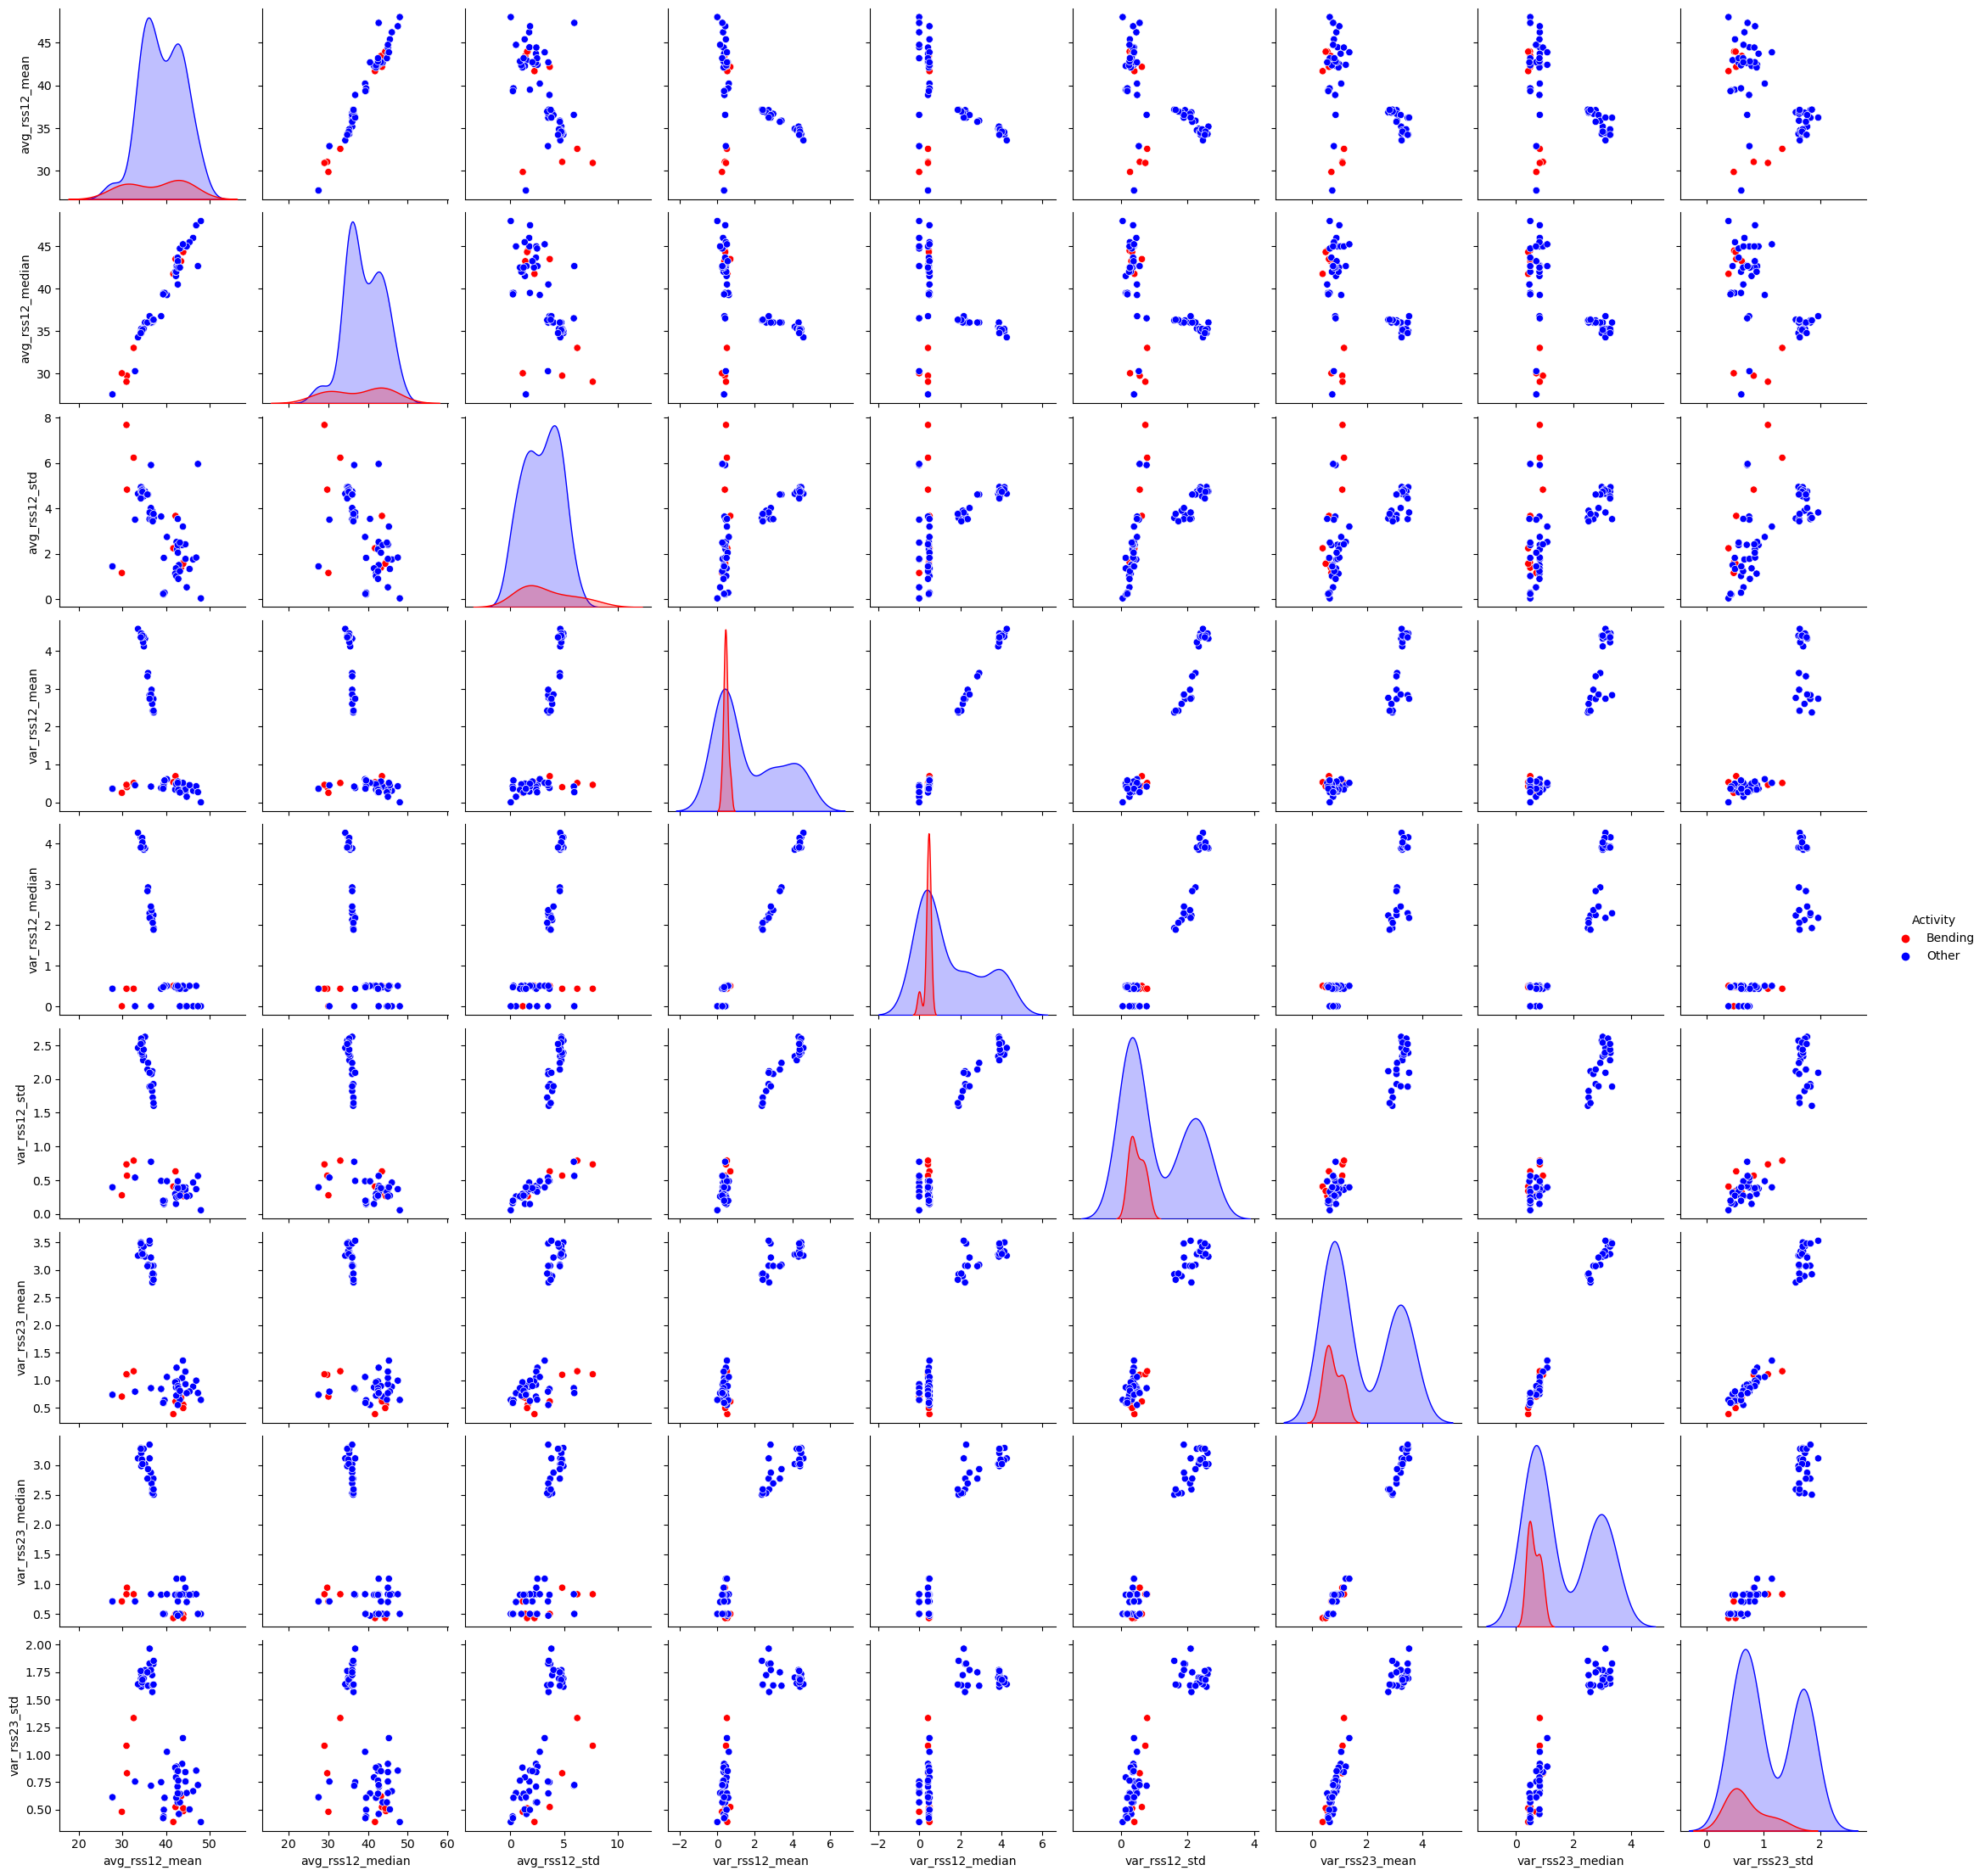

In [20]:
# Create a new column to label bending vs other activities
sliced_training_AReM_Data_Set_features.loc[:, 'Activity'] = sliced_training_AReM_Data_Set_features['filename'].apply(
    lambda x: 'Bending' if 'bending' in x else 'Other'
)

feature_columns_i = [
    'avg_rss12_mean', 'avg_rss12_median', 'avg_rss12_std',
    'var_rss12_mean', 'var_rss12_median', 'var_rss12_std', 
    'var_rss23_mean', 'var_rss23_median', 'var_rss23_std'
]

# pairplot
sns.pairplot(
    sliced_training_AReM_Data_Set_features, 
    vars=feature_columns_i, 
    hue='Activity', 
    palette={'Bending': 'red', 'Other': 'blue'}
)

plt.show()

#### ii. Splitted Plots

In [21]:
def split_time_series(dataset_dict):

    split_dataset = {}
    
    for key, df in dataset_dict.items():
        # midpoint calculation 
        midpoint = len(df) // 2
        
        # Split the DataFrame into two approxmaite length and reset the index
        part1 = df.iloc[:midpoint].reset_index(drop=True)
        part2 = df.iloc[midpoint:].reset_index(drop=True)
        
        # Append '_part1' and '_part2' to the original key as the new keys
        part1_key = f"{key}_part1"
        part2_key = f"{key}_part2"
        
        # Add the new halves to the split_dataset dictionary
        split_dataset[part1_key] = part1
        split_dataset[part2_key] = part2
        
    return split_dataset

In [22]:
split_training_dataset = split_time_series(training_dataset)

In [23]:
# split_training_dataset

In [24]:
def calculate_time_domain_features_2aii(Data_dic, variables):
    
    features_list = []
    for key, dataframe in Data_dic.items():
        # only process keys that end with '_part1'
        if key.endswith('_part1'):
            features = {'filename': key}
            for var in variables:
                # Calculate features
                features[f'{var}_mean'] = dataframe[var].mean()
                features[f'{var}_median'] = dataframe[var].median()
                features[f'{var}_std'] = dataframe[var].std()
            features_list.append(features)
            
    return pd.DataFrame(features_list)


In [25]:
variables_2aii = ['avg_rss12', 'var_rss12', 'var_rss23'] #1,2,6 
features_2aii = calculate_time_domain_features_2aii(split_training_dataset, variables_2aii)

In [26]:
# print(features_2aii.shape)
# features_2aii.head()

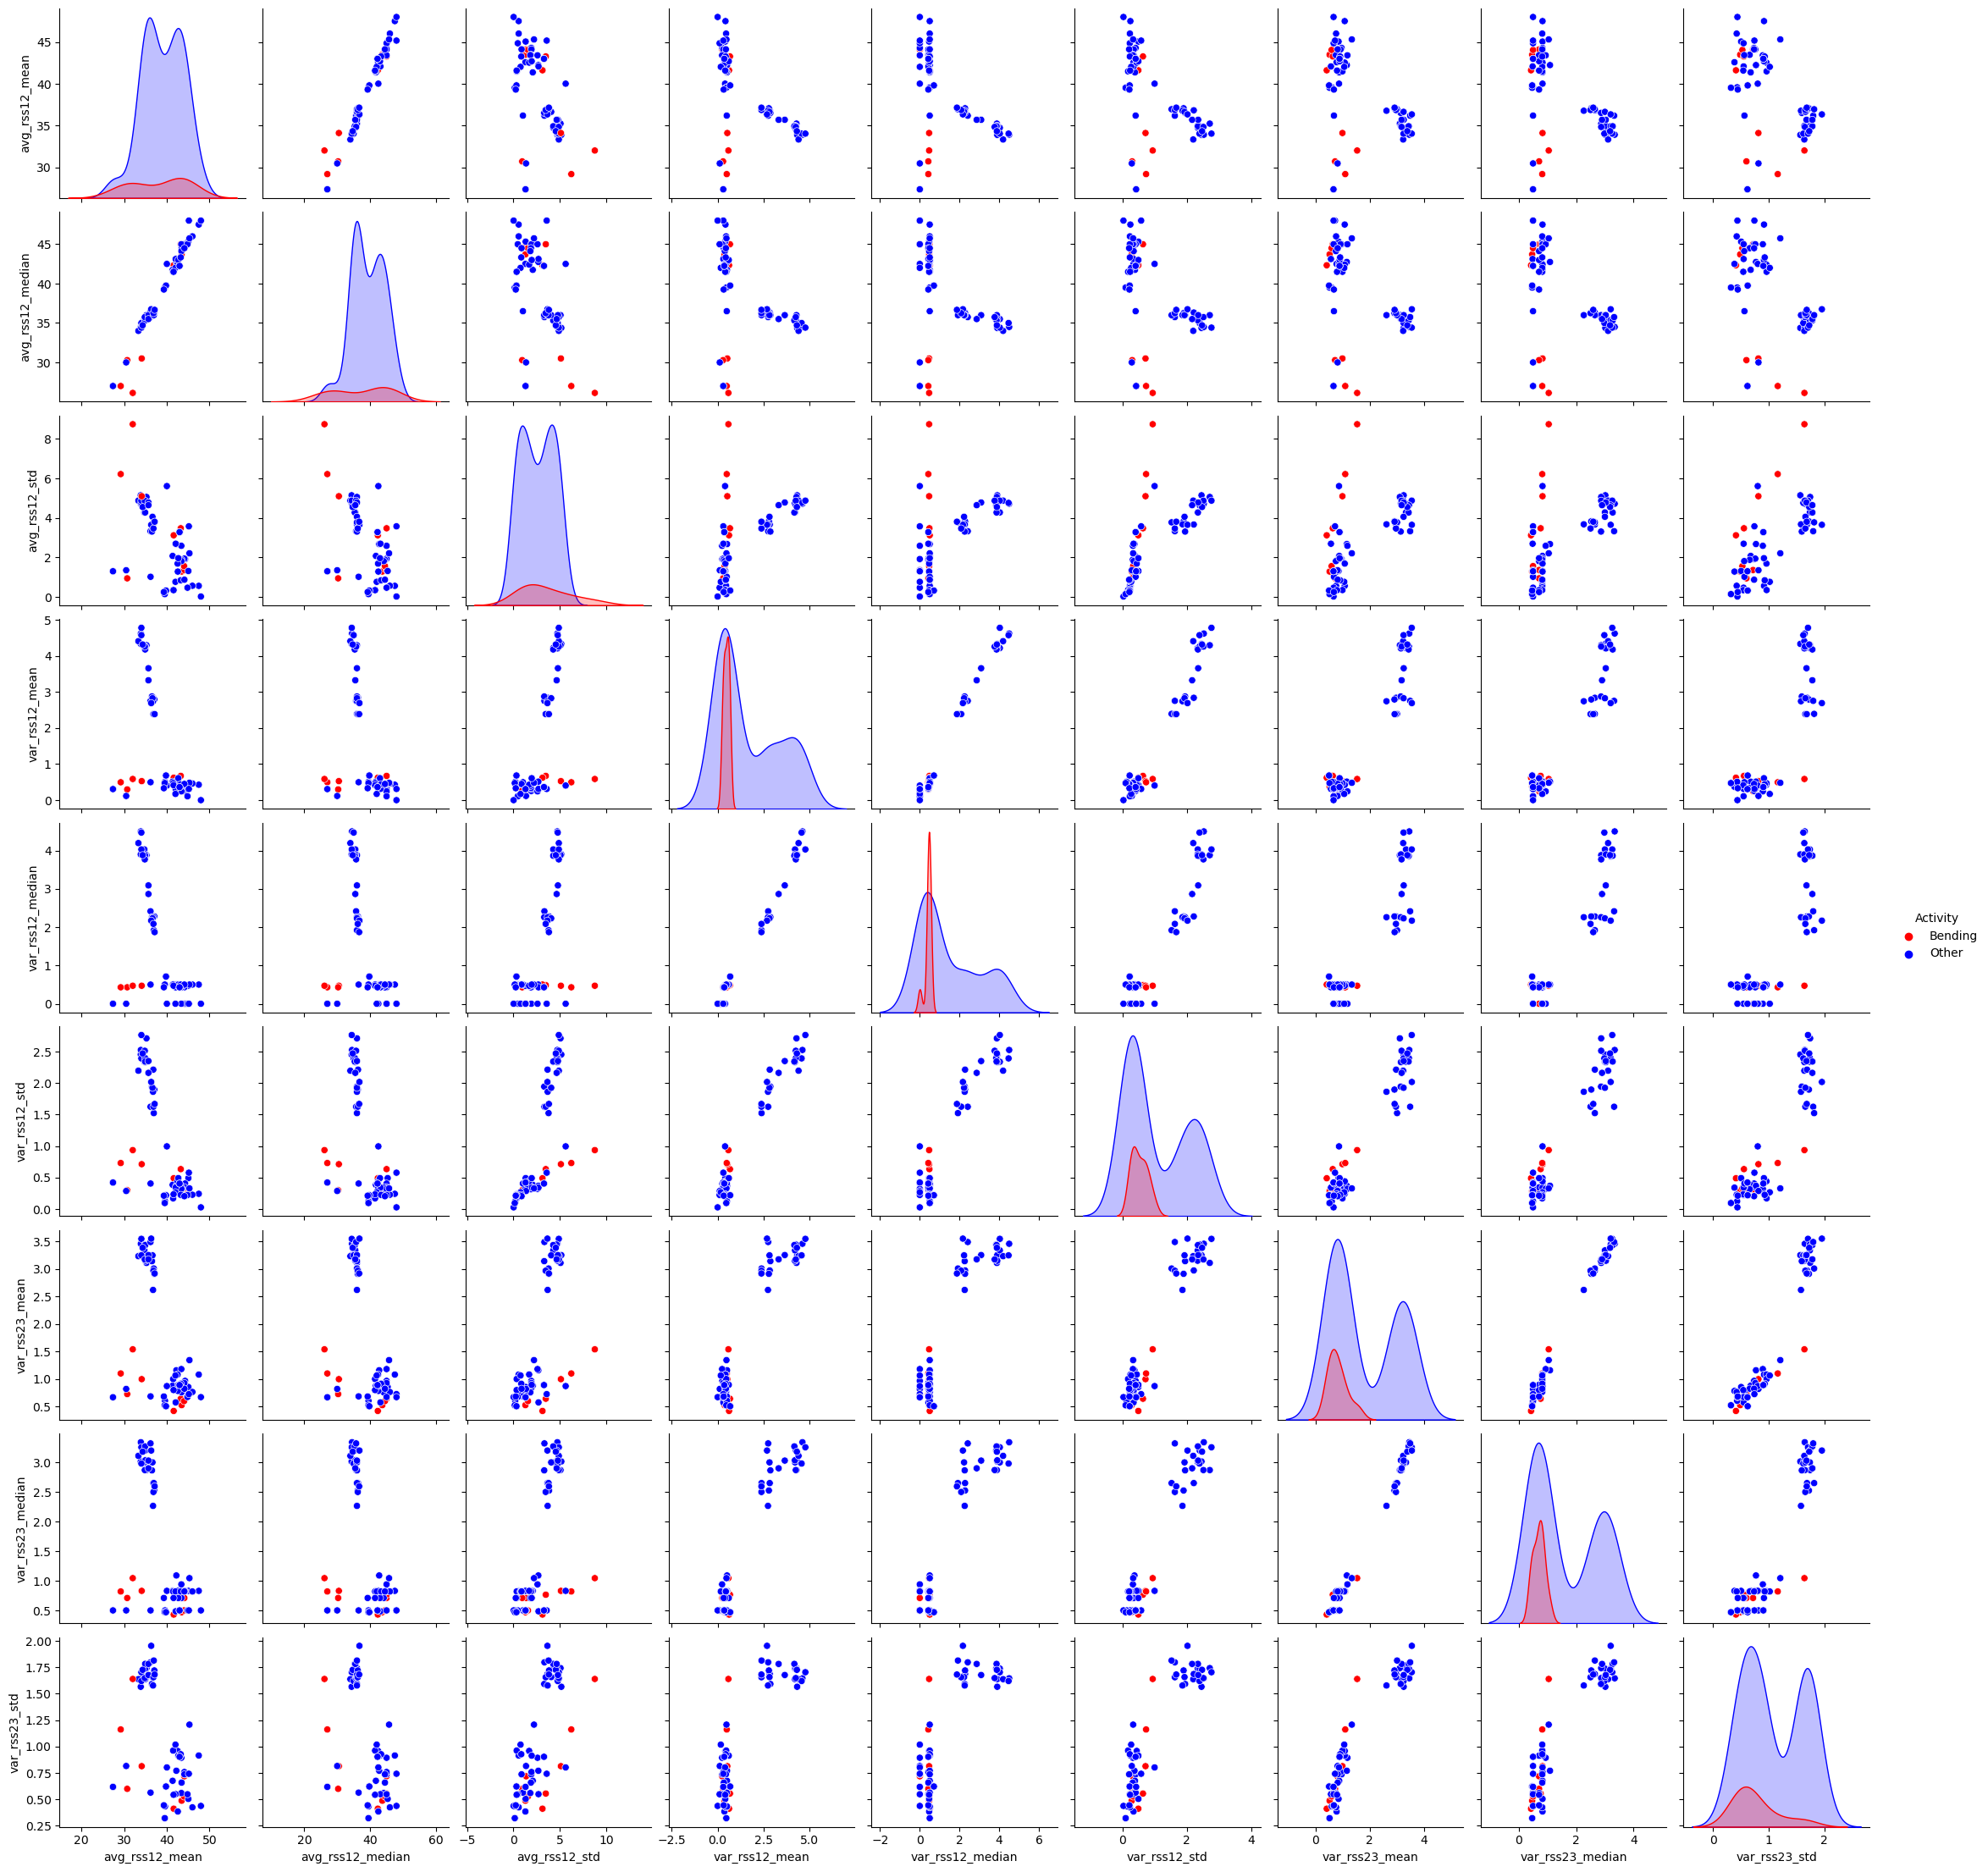

In [27]:
# Create a new column to label bending vs other activities
features_2aii.loc[:, 'Activity'] = features_2aii['filename'].apply(
    lambda x: 'Bending' if 'bending' in x else 'Other'
)

# pairplot
sns.pairplot(
    features_2aii, 
    vars=feature_columns_i, 
    hue='Activity', 
    palette={'Bending': 'red', 'Other': 'blue'}
)

plt.show()

No any considerable difference in the results with those of 2(a)i

#### iii. Time Series Segments

In [28]:
# split the dataset into l parts
def split_time_series_iii(dataset_dict, num_splits):
    split_dataset_iii = {}
    for key, df in dataset_dict.items():
        split_length = len(df) // num_splits
        for i in range(num_splits):
            start_idx = i * split_length
            end_idx = (i + 1) * split_length if i < num_splits - 1 else len(df)
            current_split = df.iloc[start_idx:end_idx].reset_index(drop=True)
            current_split_key = f"{key}_part{i+1}"
            split_dataset_iii[current_split_key] = current_split
    return split_dataset_iii

In [29]:
# Function to create features for each part
def create_features_iii(Data_dic, variables):
    features_list = []
    for key, dataframe in Data_dic.items():
        features = {'filename': key}
        for var in variables:
            features[f'{var}_mean'] = dataframe[var].mean()
            features[f'{var}_median'] = dataframe[var].median()
            features[f'{var}_std'] = dataframe[var].std()
        features_list.append(features)
    return pd.DataFrame(features_list)

In [30]:
best_score_iii = 0
best_l_iii = None
best_model_iii = None
best_features_iii = None
num_features_iii = None

# Iterate over l
for l in range(1, 21):
    # Split the dataset into l parts
    split_data = split_time_series_iii(training_dataset, num_splits=l)
    
    # feature creation 
    feature_df = create_features_iii(split_data, variables_2aii)
    
    X = feature_df.drop(['filename'], axis=1)
    y = feature_df['filename'].str.contains('bending').astype(int)
    
    # Initialize the logistic regression model
    log_reg = LogisticRegression(max_iter=1000, solver='liblinear')

    # Perform RFECV with logistic regression
    stratified_kf_iii = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)
    rfecv_iii = RFECV(estimator=log_reg, step=1, cv=stratified_kf_iii, scoring='accuracy')
    rfecv_iii.fit(X, y)
    
    # Evaluate the model's performance with cross-validation on the selected features
    X_selected_features = X.iloc[:, rfecv_iii.support_]
    cv_scores = cross_val_score(log_reg, X_selected_features, y, cv=stratified_kf_iii, scoring='accuracy')
    mean_cv_score = cv_scores.mean()
    
    # Check if the current model's score is the best
    if mean_cv_score > best_score_iii:
        best_score_iii = mean_cv_score
        best_l_iii = l
        best_model_iii = rfecv_iii.estimator_
        best_features_iii = rfecv_iii.support_
        num_features_iii = rfecv_iii.n_features_

In [31]:
# Output the best results
print(f"Best CV score: {best_score_iii}")
print(f"Best l (number of splits): {best_l_iii}")
print(f"Number of features: {num_features_iii}")

Best CV score: 0.8915873015873015
Best l (number of splits): 2
Number of features: 7


After doing some research, we use stratified cross-validation for imbalanced data, becaue stratified sampling ensures that each fold of the cross-validation process has the same proportion of class labels as the original dataset. This is particularly important in imbalanced datasets to prevent folds without representation from the minority class.

We use the cross-validation version of RFE function to determine the best values. The best pair is l = 2 and p = 7.

#### iv. Confusion Matrix

In [32]:
# Ensure X contains only the columns corresponding to True in best_features
X_best_iv = X.iloc[:, best_features_iii]

# Fit the best model 
best_model_iv = LogisticRegression(max_iter=1000, solver='liblinear')
fit = best_model_iv.fit(X_best_iv, y)

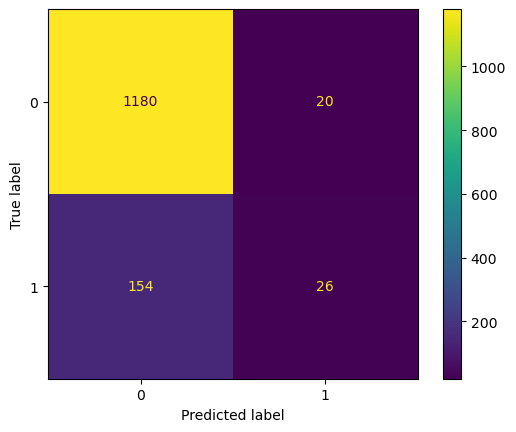

In [33]:
# confusion matrix
y_pred_iv = best_model_iv.predict(X_best_iv)
conf_matrix_iv = confusion_matrix(y, y_pred_iv)
disp_iv = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_iv)
disp_iv.plot()
plt.show()

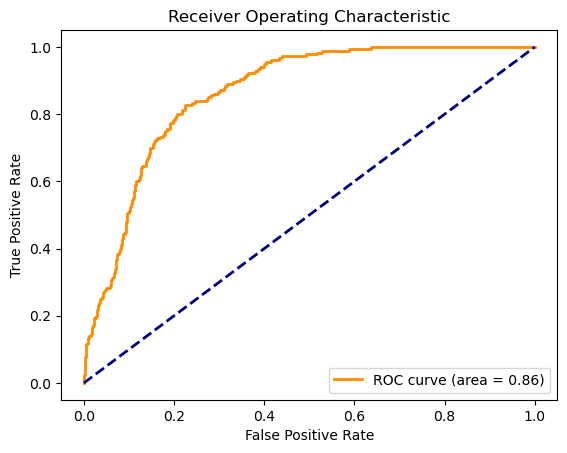

In [34]:
# ROC and AUC
y_pred_proba_iv = best_model_iv.predict_proba(X_best_iv)[:, 1]
fpr, tpr, _ = roc_curve(y, y_pred_proba_iv)
roc_auc_iv = roc_auc_score(y, y_pred_proba_iv)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_iv)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [35]:
import statsmodels.api as sm
# Logistic Regression Parameters and P-values
X_with_const = sm.add_constant(X_best_iv)  
logit_model = sm.Logit(y, X_with_const)
result = logit_model.fit(disp=0)

print("Model Parameters (βi's):\n", result.params)
print("\nP-values:\n", result.pvalues)

Model Parameters (βi's):
 const               4.652798
avg_rss12_mean     -0.232344
avg_rss12_median    0.107633
avg_rss12_std       0.710069
var_rss12_std      -0.452369
var_rss23_mean     -2.801121
var_rss23_median    0.015526
var_rss23_std       0.807838
dtype: float64

P-values:
 const               9.982086e-13
avg_rss12_mean      1.189136e-01
avg_rss12_median    4.640785e-01
avg_rss12_std       2.141691e-10
var_rss12_std       2.879317e-01
var_rss23_mean      6.502053e-03
var_rss23_median    9.849002e-01
var_rss23_std       2.173372e-01
dtype: float64


#### v. Test Classifier

In [36]:
# Split the test dataset into 'best_l' parts
split_test_data_v = split_time_series_iii(testing_dataset, num_splits=best_l_iii)

# feature creation
test_feature_v = create_features_iii(split_test_data_v, variables_2aii)

X_test_raw = test_feature_v.drop(columns=['filename'])

X_test = X_test_raw.iloc[:, best_features_iii]
y_test = test_feature_v['filename'].str.contains('bending').astype(int)

In [37]:
# Predict on the test set
y_pred_test = best_model_iv.predict(X_test)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy on Test Set: {test_accuracy}")

# Compare the cross-validation accuracy
print(f"Cross-Validation Accuracy: {best_score_iii}")

Accuracy on Test Set: 0.7894736842105263
Cross-Validation Accuracy: 0.8915873015873015


The resting accuracy looks good. However, the higher accuracy during cross-validation (0.892) compared to the test set (0.789) might suggest that the model has overfit to the training data. The process of feature selection and selecting the number of splits might have optimized the model closely to the training data's specific characteristics, which may not generalize well to the test set.

#### vi. Separation

It is a common situation of logistic regression that when the classes are well-separated, then the point estimators are not stable. In this question, the accuracy scores alone do not confirm well-separated classes causing instability though. 

#### vii. Imbalance

In [38]:
# 1 indicates 'bending' activity and 0 otherwise
feature_df['bending'] = feature_df['filename'].str.contains('bending').astype(int)

X = feature_df.drop(['filename', 'bending'], axis=1) 
y = feature_df['bending']

# Split the dataset into a balanced training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Separate minority and majority classes
not_bending = X_train[y_train == 0]
bending = X_train[y_train == 1]

# Upsample minority class
bending_upsampled = resample(bending,
                             replace=True,  # sample with replacement
                             n_samples=len(not_bending),  # match number in majority class
                             random_state=27)  # reproducible results

# Combine majority and upsampled minority class
X_train_upsampled = pd.concat([not_bending, bending_upsampled])
y_train_upsampled = pd.concat([y_train[y_train == 0], y_train[y_train == 1].loc[bending_upsampled.index]])

# New logistic regression model with balanced class weights
balanced_log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)
balanced_log_reg.fit(X_train_upsampled, y_train_upsampled)

# Predict on the validation set
y_pred = balanced_log_reg.predict(X_val)

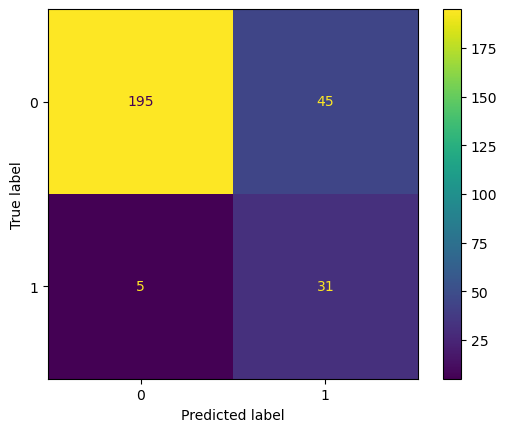

In [39]:
# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=balanced_log_reg.classes_)
disp.plot()
plt.show()

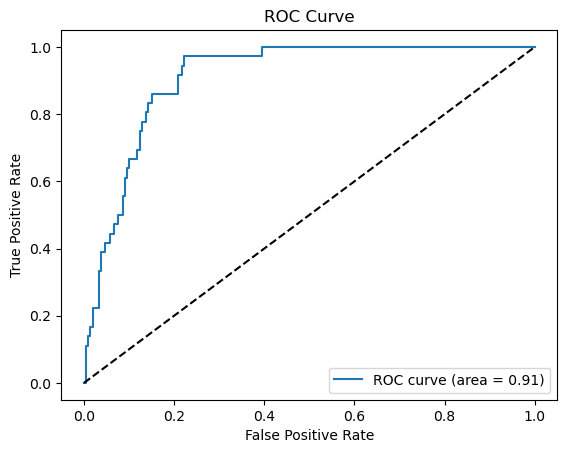

ROC AUC Score: 0.909375


In [40]:
# Calculate ROC AUC
y_pred_proba = balanced_log_reg.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
roc_auc = roc_auc_score(y_val, y_pred_proba)

# Plot ROC Curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC Score: {roc_auc}")

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments

In [41]:
best_score_bi = 0
best_l_bi = None
best_C_bi = None
best_model_bi = None
best_features_bi = None

# Range of C values to cross-validate over
C_values = np.logspace(-4, 4, 20)

# Iterate over each possible value of l
for l in range(1, 21):
    # Split the dataset into l parts
    split_data = split_time_series_iii(training_dataset, num_splits=l)
    
    # Create features for the split data
    feature_df = create_features_iii(split_data, variables_2aii)
    
    # Extract features and labels
    X = feature_df.drop(['filename'], axis=1)
    y = feature_df['filename'].str.contains('bending').astype(int)
    
    # Initialize the L1-penalized logistic regression model with cross-validation over C values
    # LogisticRegressionCV automatically performs StratifiedKFold internally
    l1_log_reg_cv = LogisticRegressionCV(Cs=C_values, cv=5, penalty='l1', solver='liblinear', max_iter=1000, random_state=1)
    
    # Fit the model
    l1_log_reg_cv.fit(X, y)
    
    # Get the score for the best C value
    mean_cv_score = np.max(l1_log_reg_cv.scores_[1].mean(axis=0))
    
    # Check if the current model's score is the best
    if mean_cv_score > best_score_bi:
        best_score_bi = mean_cv_score
        best_l_bi = l
        best_C_bi = l1_log_reg_cv.C_
        best_model_bi = l1_log_reg_cv
        # No feature selection here as L1 did it internally, we keep all features
        best_features_bi = np.ones(X.shape[1], dtype=bool)

In [42]:
# Output the best results
print(f"Best CV score: {best_score_bi}")
print(f"Best l (number of splits): {best_l_bi}")
print(f"Best C (regularization strength): {best_C_bi}")

Best CV score: 0.8920634920634921
Best l (number of splits): 2
Best C (regularization strength): [0.61584821]


#### ii. Comparison

The best cv score from l1-penalized logistic regression is similar to the one from RFE, so the performance is similar. 

In terms of the implementation. Both methods can do variable selection. The l1-penalized logistic regression is easiler to implement because it's just one optimization problem, while the RFE relies on a sequential process and it can be time-consuming. 

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments

In [43]:
def get_class(filename):
    action = filename.str.contains('bending').astype(int)
    action += filename.str.contains('cycling').astype(int) * 2
    action += filename.str.contains('lying').astype(int) * 3
    action += filename.str.contains('sitting').astype(int) * 4
    action += filename.str.contains('standing').astype(int) * 5
    action += filename.str.contains('walking').astype(int) * 6
    return action

In [44]:
C_values = np.logspace(-4, 4, 20)
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)
scaler = StandardScaler()

best_score = 0
best_l = None
best_C = None
best_model_params = None

for l in range(1, 21):
    print(l/20)
    split_data = split_time_series_iii(training_dataset, num_splits=l)
    feature_df = create_features_iii(split_data, variables_2aii)
    
    X = feature_df.drop(['filename'], axis=1)
    y = get_class(feature_df['filename'])
    X_scaled = scaler.fit_transform(X)  # Feature scaling

    for C in C_values:
        model = LogisticRegression(C=C, penalty='l1', solver='saga', max_iter=10000, multi_class='multinomial', random_state=1)
        scores = cross_val_score(model, X_scaled, y, cv=cv_strategy, scoring='accuracy')
        mean_score = np.mean(scores)
        
        if mean_score > best_score:
            best_score = mean_score
            best_l = l
            best_C = C
            best_model_params = model.get_params()

0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0


In [45]:
# identifying the best settings, retrain the model on the entire dataset
best_model = LogisticRegression(**best_model_params)
best_model.fit(X_scaled, y)

LogisticRegression(C=1.623776739188721, max_iter=10000,
                   multi_class='multinomial', penalty='l1', random_state=1,
                   solver='saga')

In [46]:
# Output the best results
print(f"Best CV score: {best_score}")
print(f"Best l (number of splits): {best_l}")
print(f"Best C (regularization strength): {best_C}")

Best CV score: 0.7241758241758243
Best l (number of splits): 1
Best C (regularization strength): 1.623776739188721


In [54]:
# evaluate the model on the test set
split_test_data = split_time_series_iii(testing_dataset, num_splits=best_l)
test_feature_df = create_features_iii(split_test_data, variables_2aii)
X_test = test_feature_df.drop(['filename'], axis=1)
y_test = get_class(test_feature_df['filename'])

# Predict on the test set using the best model
y_pred_test = best_model.predict(X_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:\n", conf_matrix)

# For multiclass ROC curves and AUC, we need to binarize the output
from sklearn.preprocessing import label_binarize

y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
y_pred_test_proba = best_model.predict_proba(X_test)

# Compute ROC curve and AUC for each class
n_classes = y_test_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_test_proba[:, i])
    roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_pred_test_proba[:, i])


Confusion Matrix:
 [[0 0 0 0 4 0]
 [0 3 0 0 0 0]
 [0 0 0 0 3 0]
 [0 0 0 0 3 0]
 [0 0 0 0 3 0]
 [0 3 0 0 0 0]]


/Users/elinorzhang/anaconda3/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/elinorzhang/anaconda3/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


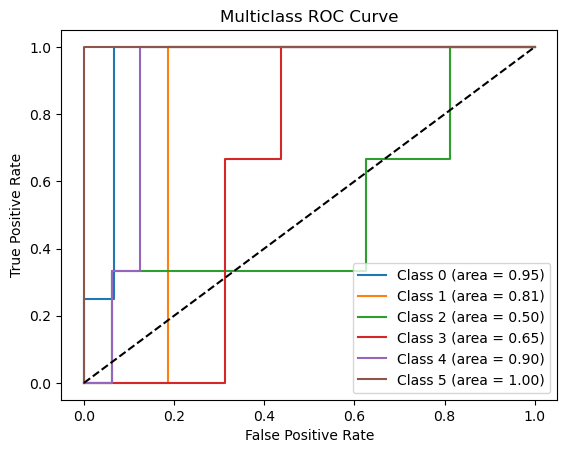

In [48]:
# Plot ROC curve for each class
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend()

#### ii. Naive Bayes

In [49]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

In [50]:
# repeat 2(c)
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

best_score_1 = 0
best_l_1 = None
best_score_2 = 0
best_l_2 = None

for l in range(1, 21):
    print(l/20)
    split_data = split_time_series_iii(training_dataset, num_splits=l)
    feature_df = create_features_iii(split_data, variables_2aii)

    ## Gaussian
    scaler = StandardScaler()
    X = feature_df.drop(['filename'], axis=1)
    y = get_class(feature_df['filename'])
    X_scaled = scaler.fit_transform(X)  # Feature scaling
    
    gnb1 = GaussianNB()
    scores = cross_val_score(gnb1, X_scaled, y, cv=cv_strategy, scoring='accuracy')
    mean_score = np.mean(scores)
    if mean_score > best_score_1:
            best_score_1 = mean_score
            best_l_1 = l
    
    ## Multinomial
    scaler = MinMaxScaler()
    X = feature_df.drop(['filename'], axis=1)
    y = get_class(feature_df['filename'])
    X_scaled = scaler.fit_transform(X)  # Feature scaling
    
    gnb2 = MultinomialNB()
    scores = cross_val_score(gnb2, X_scaled, y, cv=cv_strategy, scoring='accuracy')
    mean_score = np.mean(scores)
    if mean_score > best_score_2:
            best_score_2 = mean_score
            best_l_2 = l

0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0


In [51]:
# Output the best results
print(f"Best CV score for Guassian: {best_score_1}")
print(f"Best l (number of splits): {best_l_1}")
print(f"Best CV score for Multinomial: {best_score_2}")
print(f"Best l (number of splits): {best_l_2}")

Best CV score for Guassian: 0.7824175824175824
Best l (number of splits): 1
Best CV score for Multinomial: 0.5754725085910654
Best l (number of splits): 7


#### ii. Comparison

Between the two priors of Naive Bayes, Gaussian gives better CV score, but the score is still lower than the l1-penalized multinomial regression.

### Reference

* [stratified cross-validation 1](https://stats.stackexchange.com/questions/49540/understanding-stratified-cross-validation)
* [Stratified Cross-Validation 2](https://towardsdatascience.com/what-is-stratified-cross-validation-in-machine-learning-8844f3e7ae8e)
* [sklearn.model_selection.StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)
* [Bayes' theorem](https://www.investopedia.com/terms/b/bayes-theorem.asp#:~:text=What%20Does%20Bayes'%20Theorem%20State,probability%20of%20the%20first%20event.)
* [scipy.stats.norm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html)
* [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
* [rfecv](https://stackoverflow.com/questions/67971394/rfecv-for-feature-selection-for-logisticregression-adaboostclassifier-randomfo)
* [Logistic Regression (RFE)](https://www.kaggle.com/code/vinicius150987/logistic-regression-rfe)
* [feature_selection.RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html)
* [Multi-class Classification](https://scikit-learn.org/stable/modules/multiclass.html#:~:text=Multiclass%20classification%20is%20a%20classification,an%20apple%2C%20or%20a%20pear.)
* [Regularization path of L1- Logistic Regression](https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_path.html)
* [sklearn.naive_bayes.GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
* [sklearn.naive_bayes.MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)